In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  7525k      0 --:--:-- --:--:-- --:--:-- 7525k
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test       

In [ ]:
cd ml-100k/


[Errno 2] No such file or directory: 'ml-100k/'
/content


In [ ]:
ls


sample_data/


In [ ]:
!head u.data
!echo # line break
!wc -l u.data

head: cannot open 'u.data' for reading: No such file or directory

wc: u.data: No such file or directory


In [ ]:
!head

^C


In [ ]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
df.head()

FileNotFoundError: ignored

In [ ]:
df.columns

Index(['user_id', 'item_id', 'rating', 'timestamp'], dtype='object')

In [ ]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print( str(n_users) + ' users')
print( str(n_items) + ' items')


943 users
1682 items


In [ ]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [ ]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.30%


In this dataset, every user has rated at least 20 movies which results in a reasonable sparsity of 6.3%. This means that 6.3% of the user-item ratings have a value. Note that, although we filled in missing ratings as 0, we should not assume these values to truly be zero. More appropriately, they are just empty entries. We will split our data into training and test sets by removing 10 ratings per user from the training set and placing them in the test set.

we are doing it this to make sure that test data is not filled with all zeros. and also at the end we will calculate the mses by comparing the predicted values of the train data to the known values in the test data.


In [ ]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0],
                                        size=10,
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]

    # Test and training are truly disjoint
    assert(np.all((train * test) == 0))
    return train, test

In [ ]:
train, test = train_test_split(ratings)


#Memory based CF

It is divided into user- and item-based collaborative filtering. In either scenario, one builds a similarity matrix. For user-based collaborative filtering, the user-similarity matrix will consist of some distance metric that measures the similarity between any two pairs of users. Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.

## step 1) Similarity Matrix







In [ ]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [ ]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print (item_similarity[:4, :4])

[[1.         0.41213204 0.32378127 0.44554528]
 [0.41213204 1.         0.25727581 0.48244423]
 [0.32378127 0.25727581 1.         0.32813888]
 [0.44554528 0.48244423 0.32813888 1.        ]]


the above matrix is our similarity matrix. we will use this matrix to get the accuracy . One thing to notice, all the diagonal element are identity ie 1 and this matix is symmetric.

## step 2) weighted Average

we will now calculate the weighted rating for a user u.
It is given by sum of all other users’ ratings for item
i where the weighting is the cosine similarity between the each user and the input user
u.




In [ ]:


def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [ ]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [ ]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print( 'User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 8.41663648787214
Item-based CF MSE: 11.55270662669571


These are the final mean sq error. since user-based has less error, we will now use it for further analysis.

# Model based CF

In [ ]:
ratings = df
ratings.head()

NameError: ignored

In [ ]:
ratings.shape


(100000, 4)

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811641 sha256=126d197c60caae53ebeffc7bdd5b44d52bb0f72f2fdbe771c7b316df5cc962f7
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


we will us sklearn surprise libarary which   has been specially developed to make recommendation based on collaborative filtering easy. It has default implementation for a variety of CF algorithms.

In [ ]:
from surprise import Reader, Dataset


In [ ]:
ratings_dict = {'itemID': list(ratings.item_id),
                'userID': list(ratings.user_id),
                'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0.5, 5.0))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

Singular Value Decomposition (SVD) - it is factorization of that matrix into three matrices.

Non negative Matrix Factorization (NMF) - decomposing a matrix into the product of two small matrices.

both are implemented below

In [ ]:
# Split data into 5 folds

# data.split(n_folds=5)

from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import NMF

# svd
algo = SVD()
cross_validate(algo, data, measures=['MSE'])



{'test_rmse': array([0.93183673, 0.94027059, 0.93584915, 0.94534355, 0.93428449]),
 'fit_time': (1.5753397941589355,
  1.416581392288208,
  1.4035007953643799,
  1.3809549808502197,
  1.5227952003479004),
 'test_time': (0.12079524993896484,
  0.11576533317565918,
  0.23882079124450684,
  0.1209261417388916,
  0.27838754653930664)}

rmse for svd = 0.931

In [ ]:
# nmf
algo = NMF()
cross_validate(algo, data, measures=['MSE'])

{'test_mse': array([0.92255128, 0.92621299, 0.93560622, 0.94926355, 0.93032789]),
 'fit_time': (2.170255184173584,
  2.3559701442718506,
  2.678537130355835,
  2.2228877544403076,
  2.212235927581787),
 'test_time': (0.280026912689209,
  0.19539690017700195,
  0.10152530670166016,
  0.1132359504699707,
  0.280148983001709)}

mse for svd = 0.922

Since the difference in error between our memory based and model based methods is so great. I wanted to recheck our models. So, i tried to implement the memory based by training a knn model with metric as cosine.

In [ ]:
from surprise import KNNBasic


In [ ]:
sim_options = {'name': 'cosine', 'user_based': True}

algo = KNNBasic(sim_options = sim_options)
cross_validate(algo, data, measures=['RMSE', 'MAE'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([1.01311733, 1.01778938, 1.02046957, 1.01933354, 1.01787287]),
 'test_mae': array([0.80037853, 0.80448872, 0.80646355, 0.8061668 , 0.80425397]),
 'fit_time': (0.45891857147216797,
  0.5012280941009521,
  0.5169804096221924,
  0.6808228492736816,
  0.5424327850341797),
 'test_time': (4.656908273696899,
  3.3627712726593018,
  3.377509593963623,
  4.2314488887786865,
  3.521827459335327)}

In [ ]:

sim_options = {'name': 'cosine', 'user_based': True}

algo = KNNBasic(k = 40, sim_options = sim_options)
cross_validate(algo, data, measures=['RMSE', 'MAE'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([1.01908403, 1.01754703, 1.01477742, 1.0146043 , 1.02045076]),
 'test_mae': array([0.80521766, 0.80593271, 0.80437761, 0.80102644, 0.80588702]),
 'fit_time': (1.1249349117279053,
  0.49798154830932617,
  0.5972464084625244,
  0.5618481636047363,
  0.5362825393676758),
 'test_time': (3.5005621910095215,
  3.4105515480041504,
  4.4846930503845215,
  3.4241981506347656,
  3.598789691925049)}

In [ ]:
algo = KNNBasic()
cross_validate(algo, data, measures=['RMSE', 'MAE'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.98760567, 0.97920419, 0.97149264, 0.97823111, 0.9755163 ]),
 'test_mae': array([0.7776404 , 0.77564933, 0.76565177, 0.77298458, 0.77176474]),
 'fit_time': (0.3202972412109375,
  0.3502352237701416,
  0.3273956775665283,
  0.34377121925354004,
  0.3429121971130371),
 'test_time': (4.464260816574097,
  3.3071377277374268,
  3.3677825927734375,
  4.546188831329346,
  3.3200478553771973)}

In [ ]:
sim_options = {'name': 'cosine'}

algo = KNNBasic(k = 40, sim_options = sim_options)
cross_validate(algo, data, measures=['MSE', 'MAE'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


{'test_mse': array([1.03859526, 1.03983105, 1.02859712, 1.04226925, 1.01777505]),
 'test_mae': array([0.80499741, 0.80646321, 0.80032089, 0.80732416, 0.79891185]),
 'fit_time': (0.4648091793060303,
  0.503185510635376,
  0.5039677619934082,
  0.5064022541046143,
  0.5147254467010498),
 'test_time': (4.67339015007019,
  3.323956251144409,
  3.361227512359619,
  4.501655101776123,
  3.353078842163086)}

I implemented the knnbasic model times with all parametric combination. the error it produced with cosine similarity was around 1.038 and with msd(mean sq dist) similarity which was 0.97

Still not being satisfied with the answers, i again tried to calculate the similarity to for memory based model using sklearn cosine similarity class.

In [ ]:
ratings2 = ratings.copy()


NameError: ignored

In [ ]:
col = ['item_id', 'user_id']


In [ ]:
n_users=int(ratings2.user_id.nunique())
n_items=int(ratings2.item_id.nunique())

In [ ]:
print("n_users = ",n_users, "||", "n_items = ", n_items )

n_users =  943 || n_items =  1682


In [ ]:
from sklearn import model_selection as cv
train_data, test_data = cv.train_test_split(ratings2, test_size=0.25)

NameError: ignored

In [ ]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [ ]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [ ]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def mse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_squared_error(prediction, ground_truth)


In [ ]:
print('User-based CF MSE: ' , str(mse(user_prediction, test_data_matrix)))
print('Item-based CF MSE: ' , str(mse(item_prediction, test_data_matrix)))


User-based CF MSE:  9.705781597114228
Item-based CF MSE:  11.848074917642963


again this time around also the error produced by user-based cf was less around 9.705.

I guess this is the final result we are going to get

In [ ]:
timeit.timeit

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
%timeit pairwise_distances(train_data_matrix, metric='cosine')

NameError: ignored

In [ ]:
mses = [8.41, 9.705, .981, .931, .963]
algos = ['cosine_memory formula','cosine_memory sklearn' ,'KNN', "NMF", 'SVD']


Plotting graph to compare performances of different models

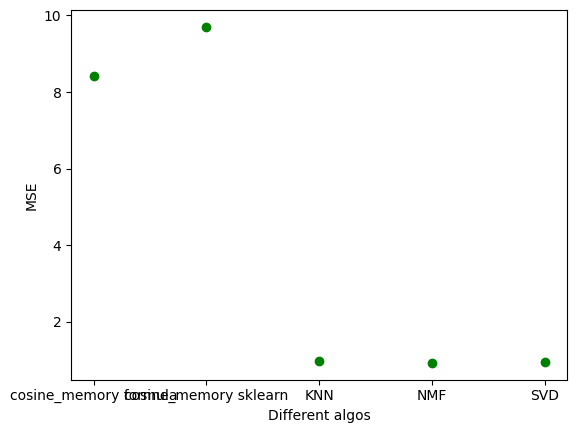

In [ ]:
mses = [8.41, 9.705, .981, .931, .963]
algos = ['cosine_memory formula','cosine_memory sklearn' ,'KNN', "NMF", 'SVD']
plt.plot(algos, mses, 'go',  )
plt.xlabel("Different algos")
plt.ylabel("MSE")
plt.show()

In [ ]:

data = pd.DataFrame({
   'cosine_memory formula':8.41 ,
   'cosine_memory sklearn': 9.705,
   'KNN': 0.981,
   'NMF': 0.931,
   'SVD': 0.963,
}, index = [0,1,2,3,4])

In [ ]:
data

,cosine_memory formula,cosine_memory sklearn,KNN,NMF,SVD
0,8.41,9.705,0.981,0.931,0.963
1,8.41,9.705,0.981,0.931,0.963
2,8.41,9.705,0.981,0.931,0.963
3,8.41,9.705,0.981,0.931,0.963
4,8.41,9.705,0.981,0.931,0.963


In [ ]:
data1 = pd.DataFrame(data = mses, index = algos, columns = ["mses"])

In [ ]:
data1

,mses
cosine_memory formula,8.410
cosine_memory sklearn,9.705
KNN,0.981
NMF,0.931
SVD,0.963


In [ ]:
fig = px.bar(data1,  y='mses', labels = {"index":" models","mses":  "mses"})
fig.update_layout(
    xaxis=dict(title='models'),
    yaxis=dict(title='Mean sq errors'),
    title = "Error produced by each model")

bar chart comparing mean sq error of diff models.

In [ ]:
fig.show()

Conclusion: from the above results it is clear that model based recommender systems perform better than memory based. We Also found that the cause of this increased performance is inherently due to the use of ml based models which vastly outperform other methods due to their ability to identify the potential clusters. This became more clear with the use of multiple variations of knn model using cosine similarity that the problem does not lie inherently within the method but the way it is executed.

In [ ]:
import plotly.express as px


In [ ]:
time = pd.DataFrame( data = [206,198, 4.672,  0.280, 0.1207], index =  ['cosine_memory formula','cosine_memory sklearn' ,'KNN', "NMF", 'SVD'], columns = ["y"])

In [ ]:
time

,y
cosine_memory formula,206.0000
cosine_memory sklearn,198.0000
KNN,4.6720
NMF,0.2800
SVD,0.1207


In [ ]:
fig = px.bar(time,  y="y")
fig.update_yaxes(type='log')
fig.update_layout(
    xaxis=dict(title='Algorithms'),
    yaxis=dict(title='Time Taken (ms)'),
    title = "Time taken for Execution")

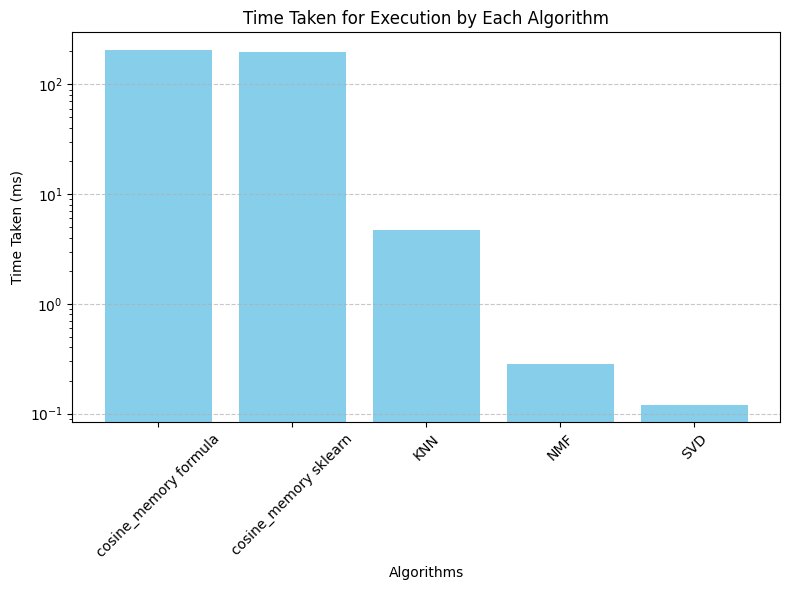

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
time = pd.DataFrame(data=[206, 198, 4.672, 0.280, 0.1207],
                    index=['cosine_memory formula', 'cosine_memory sklearn', 'KNN', 'NMF', 'SVD'],
                    columns=['Time Taken (ms)'])

# Plotting the graph with log scale on the y-axis
plt.figure(figsize=(8, 6))
plt.bar(time.index, time['Time Taken (ms)'], color='skyblue')
plt.yscale('log')  # Set log scale for the y-axis
plt.xlabel('Algorithms')
plt.ylabel('Time Taken (ms)')
plt.title('Time Taken for Execution by Each Algorithm')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()